<a href="https://colab.research.google.com/github/alexocayanez/xAI-CheXpert-radiology/blob/main/xAI_cheXpert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import math
import os
import random
import time
import typing

from tqdm import tqdm
import cv2; print(f"OpenCV version: {cv2.__version__}")
import matplotlib.pyplot as plt
import numpy as np; print(f"Numpy version: {np.__version__}")
import pandas as pd; print(f"Pandas version: {pd.__version__}")
from PIL import Image
import seaborn as sns
import sklearn.metrics
import sklearn.model_selection
import torch; print(f"PyTorch version: {torch.__version__}")
import torch.nn as nn
import torch.nn.functional as F
import torchvision

OpenCV version: 4.11.0
Numpy version: 1.26.4
Pandas version: 2.2.2
PyTorch version: 2.5.1+cu124


In [ ]:
!pip install mlflow dagshub optuna --quiet
import mlflow
import dagshub
import optuna

# Data preparation

## Download CheXpert dataset

There are two options, one for one time use and another for recurrent use using Google Drive. Execute just the necessary cells.

Ctrl + M M to convert code cell to text

Ctrl + M Y to convert text cell to code

### Option 1: Download directly to Colab session storage
They data will be deleted every time the session is restored. It takes around 5 minutes to download and unzip the dataset.


1. Retrieve a Kaggle API key formatted as as kaggle.json file.
2. Upload it into the content folder (the default one in Files) in the Colab session storage.
3. Execute the following code block.

!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json # Move API key and set permissions

!kaggle datasets download ashery/chexpert -p /content # Download zip dataset from kaggle
dataset_zip = "/content/chexpert.zip"

!mkdir -p /content/chexpert/CheXpert-v1.0-small
!unzip -q {dataset_zip} -d /content/chexpert/CheXpert-v1.0-small  # Unzip the dataset in appropiate directory

os.remove(dataset_zip) # Remove ZIP file to save space

CHEXPERT_PATH = "/content/chexpert" # Base path of the dataset

### Option 2: Access using Google Drive


In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

CHEXPERT_PATH = '/content/drive/MyDrive/chexpert'
!ls {CHEXPERT_PATH}

print("Content of CheXpert-v1.0-small inside selected directory:")
!ls {CHEXPERT_PATH}/CheXpert-v1.0-small


Mounted at /content/drive
 CheXpert-v1.0-small  'ranking annotations'
Content of CheXpert-v1.0-small inside selected directory:
train  train.csv  valid  valid.csv


Inside the selected directory in Drive, you should have a folder called CheXpert-v1.0-small containing the Kaggle dataset.

#### Download the dataset directly to Google Drive

It is possible to download the dataset to Drive directly to the selected CHEXPERT_PATH directory in your drive.

1. Get the Kaggle API key
2. Upload the key into Colab files

from google.colab import files
files.upload()

3. Download the dataset in the Google Drive mount. Takes around 1h.

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!mkdir -p {CHEXPERT_PATH}
!kaggle datasets download ashery/chexpert -p {CHEXPERT_PATH}

!unzip {CHEXPERT_PATH}/chexpert.zip -d {CHEXPERT_PATH}/CheXpert-v1.0-small
!rm {CHEXPERT_PATH}/chexpert.zip

## Dataset exploration

Read the pandas dataframes and filter them only with frontal images.

In [ ]:
train_path = CHEXPERT_PATH + "/CheXpert-v1.0-small/train.csv"
train_df = pd.read_csv(train_path)
train_df = train_df[train_df['Frontal/Lateral'] == 'Frontal']
train_df["Patient number"] = train_df["Path"].str.extract(r"patient(\d+)")

test_path = CHEXPERT_PATH + "/CheXpert-v1.0-small/valid.csv"
test_df = pd.read_csv(test_path)
test_df = test_df[test_df['Frontal/Lateral'] == 'Frontal']
test_df["Patient number"] = test_df["Path"].str.extract(r"patient(\d+)")

In [ ]:
train_df.head()

,Path,Sex,Age,Frontal/Lateral,AP/PA,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices,Patient number
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,AP,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,1.0,00001
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,AP,NaN,NaN,-1.0,1.0,NaN,-1.0,-1.0,NaN,-1.0,NaN,-1.0,NaN,1.0,NaN,00002
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,AP,NaN,NaN,NaN,1.0,NaN,NaN,-1.0,NaN,NaN,NaN,NaN,NaN,1.0,NaN,00002
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,AP,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,00003
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,PA,1.0,0.0,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,0.0,NaN,NaN,NaN,00004


The radiographs are labeled for the presence of 14 observations as positive, negative, or uncertain.

In [ ]:
LABELS = [
    'No Finding', 'Enlarged Cardiomediastinum', 'Cardiomegaly',
    'Lung Opacity', 'Lung Lesion', 'Edema', 'Consolidation',
    'Pneumonia', 'Atelectasis', 'Pneumothorax', 'Pleural Effusion',
    'Pleural Other', 'Fracture', 'Support Devices'
]
NR_LABELS = len(LABELS)

### Image visualization tool by labels

Use Ctrl + Click to select multiple labels in the output. Adjust the number of images you want to display

In [ ]:
import ipywidgets as widgets
from IPython.display import display

# Create a dropdown selection for training or test data.
df_dropdown = widgets.Dropdown(
    options=["Training", "Test"],
    description='Select training or test data:',
    style={'description_width': 'initial'},
)

# Create a multiple-selection widget for labels.
label_selector = widgets.SelectMultiple(
    options=LABELS,
    description='Select Labels:',
    style={'description_width': 'initial'}
)

def display_images(selected_data, selected_labels, num_images=9):
  """
  Filters the DataFrame to images that have all of the selected labels marked as positive (1)
  and displays a sample of images.

  Parameters:
      selected_labels (tuple): A tuple of labels selected from the widget.
      num_images (int): Number of images to display (default is 9).
  """

  # Choose the dataset depending on the selection
  if selected_data.lower() == "training":
    df = train_df
  elif selected_data.lower() == "test":
    df = test_df
  else:
    print("No data selected.")
    return

  # If no labels are selected, prompt the user to select at least one.
  if not selected_labels:
    print("No labels selected. Please select one or more labels.")
    return

  # Filter the DataFrame: For the selected labels, check that all columns have a value of 1.
  df_selected = df[df[list(selected_labels)].eq(1).all(axis=1)]

  # If there are no matching images, display a message.
  if df_selected.empty:
    print(f"No images found with the labels: {', '.join(selected_labels)}")
    return

  # Randomly sample images (up to num_images) from the filtered DataFrame.
  sample_count = min(num_images, len(df_selected))
  sampled_df = df_selected.sample(n=sample_count, random_state=42)

  # Determine grid size dynamically (using the ceiling of the square root)
  grid_size = math.ceil(math.sqrt(sample_count))
  fig, axes = plt.subplots(grid_size, grid_size, figsize=(10, 10))

  axes = np.atleast_1d(axes).flatten()

  for ax, (_, row) in zip(axes, sampled_df.iterrows()):
    try:
      img = cv2.imread(os.path.join(CHEXPERT_PATH , row['Path']), cv2.IMREAD_GRAYSCALE)
      ax.imshow(img, cmap='gray')
      ax.set_title(f"Patient number: {row['Patient number']}" , fontsize=8)
      ax.axis('off')
    except Exception as e:
      ax.text(0.5, 0.5, f"Error loading image:\n{e}", ha='center', va='center')
      ax.axis('off')

  # Hide any unused subplots
  for ax in axes[len(sampled_df):]:
      ax.axis('off')

  fig.suptitle(f'Selected labels: {selected_labels}', fontsize=14)

  plt.tight_layout()
  plt.show()

# Create an interactive widget linking the multiple-selection widget and number slider to the function.
widgets.interact(display_images,
                 selected_data = df_dropdown,
                 selected_labels = label_selector,
                 num_images=(1, 16, 1))

interactive(children=(Dropdown(description='Select training or test data:', options=('Training', 'Test'), styl…

<function __main__.display_images(selected_data, selected_labels, num_images=9)>

### Pleural effusion label

In [ ]:
train_df = train_df[train_df["Pleural Effusion"].notna()]
print(f"Positive pleural effusion samples: {len(train_df[train_df['Pleural Effusion'].astype(int)==1])}")
print(f"Negative pleural effusion samples: {len(train_df[train_df['Pleural Effusion'].astype(int)==0])}")
print(f"Uncertain pleural effusion samples: {len(train_df[train_df['Pleural Effusion'].astype(int)==-1])}")

Positive pleural effusion samples: 76899
Negative pleural effusion samples: 25299
Uncertain pleural effusion samples: 9578


There are aound 10% of uncertain Pleural Effusion datapoints from all the labelled patients. There is a class imbalance favouring the positive label in a ratio of around 3:1.

## Pytorch datasets and dataloaders

In [65]:
class CheXpertDataset(torch.utils.data.Dataset):

  def __init__(self, root_dir, csv_file="", uncertainty="u-ignore", subset_ratio = 1.0, stage="train"):
    self.stage = stage
    self.root_dir = root_dir
    self.transform = torchvision.transforms.Compose([
        #torchvision.transforms.Resize((224, 224)), # Resize to 224x224
        torchvision.transforms.ToTensor(),  # Converts image to [0, 1] and to shape (1, 224, 224)
        # torchvision.transforms.Normalize(mean=[0.5], std=[0.5]) # Add normalization if needed
        ])
    self.label = "Pleural Effusion"

    if self.stage == 'pred':
      self.file_names = [f for f in os.listdir(root_dir)]
    else:
      self.data = pd.read_csv(csv_file)
      self.data = self.data[self.data['Frontal/Lateral'] == 'Frontal'] # Select only frontal images
      self.data = self.data[self.data[self.label].notna()] # Only not NaN value for the selected label

      # Load only a subset if selected, reseting the indexes of the df
      if subset_ratio<1:
        subset_size = int(len(self.data) * subset_ratio)
        self.indices = random.sample(range(len(self.data)), subset_size)
        self.data = self.data.iloc[self.indices].reset_index(drop=True)

      # Uncertainty approaches
      # 1) U-ignoring: ignore uncertain datapoints
      if uncertainty=="u-ignore":
        self.data = self.data[self.data[self.label] != -1]
      # 2) U-zeroes: all uncertain datapoints are considered as negative
      elif uncertainty=="u-zeroes":
        self.data.loc[:, self.label] = self.data.loc[:, self.label].replace({-1: 0})
      # 3) U-ones: all uncertain datapoints are considered as positive
      elif uncertainty=="u-ones":
        self.data.loc[:, self.label] = self.data.loc[:, self.label].replace({-1: 1})
      else:
        raise ValueError("Selected uncertainty method does not exist.")

  def save_tensor_data(self):
    image_paths = self.data['Path'].values
    for idx, row in tqdm(image_paths, total=len(image_paths)):
      img_path = os.path.join(CHEXPERT_PATH, row['Path'])
      img = Image.open(img_path).convert('L')
      img = self.transform(img)
      torch.save(img, os.path.splitext(img_path)[0] + ".pt")

  def __len__(self) -> int:
    if self.stage == 'pred':
      return len(self.file_names)
    return len(self.data)

  def __getitem__(self, idx) -> typing.Tuple[torch.tensor, np.float64]:
    if self.stage == 'pred':
      img_path = os.path.join(self.root_dir, self.file_names[idx])
      label = torch.tensor([-1])  # -1 as a placeholder for unknown label

    else:
      row = self.data.iloc[idx]
      img_path = os.path.join(self.root_dir, row['Path'])
      label = torch.tensor([row[self.label]])

    img = Image.open(img_path).convert('L')
    img = self.transform(img)

    return img, label

class OversampleNegativeDataLoader(torch.utils.data.DataLoader):
  def __init__(self, dataset, labels, batch_size, num_workers=2, pin_memory=True):
    classes, counts = np.unique(labels, return_counts=True)
    class_counts = dict(zip(classes, counts))
    # Compute sample weights: inverse frequency of the label
    sample_weights = np.array([1.0 / class_counts[label] for label in labels])

    sampler = torch.utils.data.WeightedRandomSampler(
        weights=sample_weights,
        num_samples=len(sample_weights),
        replacement=True
    )

    super().__init__(
        dataset=dataset,
        batch_size=batch_size,
        sampler=sampler,
        num_workers=num_workers,
        pin_memory=pin_memory,
        shuffle=False #As we are sampling
    )

def get_dataloaders(batch_size, root_dir=CHEXPERT_PATH, validation=0, train_subset=1, val_split="stratified", verbose=True):
  all_train_dataset = CheXpertDataset(
      root_dir=root_dir,
      csv_file= root_dir + "/CheXpert-v1.0-small/train.csv",
      uncertainty="u-ignore",
      subset_ratio=train_subset
      )
  test_dataset = CheXpertDataset(
      root_dir=root_dir,
      csv_file= root_dir + "/CheXpert-v1.0-small/valid.csv",
      )
  if validation:
    if val_split == "stratified":
      train_indices, valid_indices = sklearn.model_selection.train_test_split(
          np.arange(len(all_train_dataset)),
          test_size=validation,
          stratify=all_train_dataset.data[all_train_dataset.label].values,  # Ensures same class distribution in both splits
          random_state=42  # For reproducibility
          )
      train_dataset = torch.utils.data.Subset(all_train_dataset, train_indices)
      valid_dataset = torch.utils.data.Subset(all_train_dataset, valid_indices)
    elif val_split == "random":
      valid_length = int(validation * len(all_train_dataset))
      train_length = len(all_train_dataset) - valid_length
      train_dataset, valid_dataset=torch.utils.data.random_split(all_train_dataset,(train_length, valid_length))
  else:
    train_dataset = all_train_dataset

  # To deal with class imbalance, oversample the minority class
  train_dataloader = OversampleNegativeDataLoader(
      dataset = train_dataset,
      labels= all_train_dataset.data.iloc[train_indices][all_train_dataset.label].values,
      batch_size = batch_size
      )
  test_dataloader = torch.utils.data.DataLoader(dataset = test_dataset)
  if validation:
    valid_dataloader = torch.utils.data.DataLoader(
        dataset = valid_dataset,
        batch_size = batch_size,
        shuffle = True,
        num_workers=2,
        pin_memory=True
        )
  else:
    valid_dataloader = None

  if verbose:
    print(f"Train: {len(train_dataset)} datapoints in {len(train_dataloader)} batches.")
    if validation: print(f"Validation: {len(valid_dataset)} datapoints in {len(valid_dataloader)} batches.")
    print(f"Test: {len(test_dataset)} datapoints.")

  return train_dataloader, valid_dataloader, test_dataloader

Q: How the train validation split should be done?
- Randomly? Which size? We should take into account class imbalance. Model should not predict always the same class.

- Should the sets of training and validation patients be not overlapping?

In [66]:
all_train_dataset = CheXpertDataset(csv_file=train_path, root_dir=CHEXPERT_PATH, uncertainty="u-ignore")
#all_train_dataset.save_tensor_data()

train_length = int(0.95 * len(all_train_dataset))
valid_length = len(all_train_dataset) - train_length

train_dataset, valid_dataset=torch.utils.data.random_split(all_train_dataset,(train_length, valid_length))

test_dataset = CheXpertDataset(csv_file=test_path, root_dir=CHEXPERT_PATH)

print(f"Number training datapoints: {len(train_dataset)}")
print(f"Number validation datapoints: {len(valid_dataset)}")
print(f"Number test datapoints: {len(test_dataset)}")


Number training datapoints: 97088
Number validation datapoints: 5110
Number test datapoints: 202


In [80]:
train_dataset[12432][0].shape

torch.Size([1, 320, 390])

In [63]:
def profile_dataset(dataset):
    start = time.time()
    for idx in tqdm(range(len(dataset))):
      img = dataset[idx]
    end = time.time()
    print(f"Total data loading time: {end - start:.2f} seconds")

profile_dataset(all_train_dataset)

  1%|          | 1065/102198 [01:07<1:46:24, 15.84it/s]


KeyboardInterrupt: 

# Model training

## Models

In [ ]:
class DenseNet121(torch.nn.Module):
  def __init__(self, out_size=1, pretrained=True):
    super(DenseNet121, self).__init__()
    self.pretrained = pretrained
    self.densenet121 = torchvision.models.densenet121(weights="DEFAULT" if self.pretrained else None)
    self.densenet121.features.conv0 = torch.nn.Conv2d(1, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    self.densenet121.classifier = torch.nn.Linear(self.densenet121.classifier.in_features, out_size)
    if pretrained:
      for param in self.densenet121.parameters():
        param.requires_grad = False
      for param in self.densenet121.classifier.parameters():
        param.requires_grad = True

  def forward(self, x):
    x = self.densenet121(x)
    return x

class ResNet34(nn.Module):
  def __init__(self, out_size=1, pretrained=True):
    super(ResNet34, self).__init__()
    self.pretrained = pretrained
    weights = "DEFAULT" if pretrained else None
    self.resnet34 = torchvision.models.resnet34(weights=None)
    self.resnet34.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
    self.resnet34.fc = nn.Linear(self.resnet34.fc.in_features, out_size)
    if pretrained:
      for param in self.resnet34.parameters():
        param.requires_grad = False
      for param in self.resnet34.fc.parameters():
        param.requires_grad = True

  def forward(self, x):
    x = self.resnet34(x)
    return x

In [ ]:
def n_weights(model): return sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"ResNet34 weights: {n_weights(ResNet34())}")
print(f"DenseNet121 weights: {n_weights(DenseNet121())}")

ResNet34 weights: 513


Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth
100%|██████████| 30.8M/30.8M [00:00<00:00, 115MB/s]


DenseNet121 weights: 1025


## Train and test functions

In [48]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(f"Training on {device}")
torch.backends.cudnn.benchmark = True

def train(model, params, dataloader_train, dataloader_val):
  print(f"Training the model {model.__class__.__name__}")
  model.to(device)
  optimizer = torch.optim.SGD(model.parameters(), lr=params["lr"], momentum=0.9, weight_decay=1e-4)
  loss = torch.nn.BCEWithLogitsLoss()
  min_loss = 1e6

  train_start = []
  train_end = []
  train_losses = []
  val_losses = []
  train_accs = []
  val_accs = []

  for epoch in range(0, params["nr_epochs"]):
    # Train the model in one iteration of the training data
    train_start.append(time.time()) # training starts
    loss_train, acc_train = train_epoch(model, dataloader_train, optimizer, criterion=loss)
    train_losses.append(loss_train)
    train_accs.append(acc_train)
    train_end.append(time.time()) # training ends

    # Perform validation of the epoch if given validation data
    if dataloader_val != None:
      loss_val, acc_val = validate_epoch(model, dataloader_val, optimizer, criterion=loss)
      val_losses.append(loss_val)
      val_accs.append(acc_val)
      print(f"Epoch {epoch + 1} Training loss: {loss_train:.3f}  Valid loss: {loss_val:.3f}  Train acc: {acc_train:.3f}  Val acc: {acc_val:.3f}")
      if loss_val < min_loss: min_loss = loss_val
    else:
      print(f"Epoch {epoch + 1} Training loss: {loss_train:.3f}  Train acc: {acc_train:.3f}")

  train_time = np.array(train_end) - np.array(train_start)
  print("Training finished. \n Training time for each epoch: {} seconds".format(train_time.round(0)))

  training_metrics = {
    "train_losses": train_losses,
    "val_losses": val_losses,
    "train_accs": train_accs,
    "val_accs": val_accs
  }
  return training_metrics

def train_epoch(model, dataloader_train, optimizer, criterion):
  running_loss = 0.0
  correct = 0
  total = 0
  model.train()

  for batch, (img, target) in enumerate(tqdm(dataloader_train)):

    img, target = img.to(device), target.to(device)
    out = model(img)
    loss = criterion(out, target)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    running_loss += loss.item()

    predicted = (out > 0).float()  # since using BCEWithLogitsLoss
    correct += (predicted == target).sum().item()
    total += target.numel()

  acc = correct / total if total > 0 else 0

  return running_loss / len(dataloader_train), acc

def validate_epoch(model, dataloader_val, optimizer, criterion):
  val_loss = 0.0
  correct = 0
  total = 0
  model.eval()

  with torch.no_grad():
    for i, (img, target) in enumerate(tqdm(dataloader_val)):

      img, target = img.to(device), target.to(device)
      out = model(img)
      loss = criterion(out, target)
      val_loss += loss.item()

      predicted = (out > 0).float()
      correct += (predicted == target).sum().item()
      total += target.numel()

  acc = correct / total if total > 0 else 0

  return val_loss / len(dataloader_val), acc

def plot_train_vs_valid(train_metrics, val_metrics, metric_name):
    """
    Plots training and validation metrics over epochs.

    Parameters:
      train_metrics (list or array): Metric values for the training set over epochs.
      valid_metrics (list or array): Metric values for the validation set over epochs.
      metric_name (str): Name of the metric to be plotted (e.g., 'Accuracy', 'Loss').
    """
    epochs = range(1, len(train_metrics) + 1)

    plt.figure(figsize=(10, 6))
    plt.plot(epochs, train_metrics, label="Training " + metric_name, marker='o')
    if len(val_metrics) > 0:
      plt.plot(epochs, val_metrics, label="Validation " + metric_name, marker='o')
    plt.xlabel("epochs")
    plt.xticks(ticks=epochs)
    plt.ylabel(metric_name)
    plt.title(f"Training vs validation {metric_name}")
    plt.legend()
    plt.grid(True)

    # Save the plot into a temporary directory
    image_path = os.path.join("/tmp", f"{metric_name}_train_vs_valid.png")
    plt.savefig(image_path)
    plt.close()

    return image_path

def test(model, dataloader_test, checkpoint=None):
  #torch.backends.cudnn.benchmark = True
  print(f"Testing the model {model.__class__.__name__}")

  if checkpoint != None and torch.cuda.is_available():
    model_checkpoint = torch.load(checkpoint)
    model.load_state_dict(model_checkpoint['state_dict'])

  model.to(device)
  model.eval()

  true_labels = []
  predictions = []

  with torch.no_grad():
    for i, (img, target) in enumerate(tqdm(dataloader_test)):

      img, target = img.to(device), target.to(device)
      true_labels.append(target)

      # Ensure proper dimensionality of images
      bs, c, h, w = img.size()
      img = img.view(-1, c, h, w)

      predictions.append(model(img))

  return torch.cat(true_labels, dim=0), torch.cat(predictions, dim=0)


def roc_curve_and_auc(true_labels, probabilities, filename="roc_curve.png"):
    ''' # Convert tensors to numpy arrays.
    if torch.is_tensor(true_labels): true_labels = true_labels.cpu().numpy()
    if torch.is_tensor(predictions): predictions = predictions.cpu().numpy() '''

    ''' # If predictions have more than one dimension, flatten them.
    if predictions.ndim > 1:
        predictions = predictions.flatten() '''

    # Compute ROC curve and AUC score.
    fpr, tpr, _ = sklearn.metrics.roc_curve(true_labels, probabilities)
    roc_auc = sklearn.metrics.auc(fpr, tpr)

    # Create ROC plot.
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color="darkorange", lw=2, label=f"ROC curve, AUC={roc_auc:.2f}")
    plt.plot([0, 1], [0, 1], color="navy", lw=2, linestyle="--")
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic (ROC)")
    plt.legend(loc="lower right")

    # Save the plot to a temporary directory.
    image_path = os.path.join("/tmp", filename)
    plt.savefig(image_path)
    plt.close()

    return image_path, roc_auc

def confusion_matrix(true_labels, predicted_labels, filename="confusion_matrix.png"):

  ''' # Convert tensors to numpy arrays.
  if torch.is_tensor(true_labels): true_labels = true_labels.cpu().numpy()
  if torch.is_tensor(predictions): predictions = predictions.cpu().numpy() '''


  # Compute confusion matrix.
  cm = sklearn.metrics.confusion_matrix(true_labels, predicted_labels)

  # Create a pandas DataFrame for the confusion matrix.
  df_cm = pd.DataFrame(cm, index=["Actual 0", "Actual 1"],
                            columns=["Predicted 0", "Predicted 1"])

  # Create a heatmap plot of the contingency table.
  plt.figure(figsize=(6, 4))
  sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues")
  plt.title("Contingency Table")
  plt.ylabel("Actual")
  plt.xlabel("Predicted")

  image_path = os.path.join("/tmp", filename)
  plt.savefig(image_path)
  plt.close()

  return image_path


Training on cpu


## Training experiments

In [ ]:
def set_dagshub_mlflow():
  dagshub.init(repo_name="xAI-CheXpert-radiology", repo_owner="alexocayanez", mlflow=True)
  os.environ["MLFLOW_TRACKING_USERNAME"] = "ee47c8c4a6275109d3c8186c17b6b569ed9ef30b"
  os.environ["MLFLOW_TRACKING_URI"] = "https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow"
  mlflow.set_tracking_uri('https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow')

def get_or_create_experiment_id(name):
  exp = mlflow.get_experiment_by_name(name)
  if exp is None:
    exp_id = mlflow.create_experiment(name)
    return exp_id
  return exp.experiment_id

set_dagshub_mlflow()

❗❗❗ AUTHORIZATION REQUIRED ❗❗❗

Output()



Open the following link in your browser to authorize the client:
https://dagshub.com/login/oauth/authorize?state=dfb50ffe-51b5-4146-bbec-f7644505aa85&client_id=32b60ba385aa7cecf24046d8195a71c07dd345d9657977863b52e7748e0f0f28&middleman_request_id=d481b0fce1ecde309db8d2e7392600a934218105e5e8689733a8bf02bc16878f




Accessing as alexocayanez

Initialized MLflow to track repo "alexocayanez/xAI-CheXpert-radiology"

Repository alexocayanez/xAI-CheXpert-radiology initialized!

In [49]:
def log_train(model, params, train_dataloader, valid_dataloader):
  mlflow.log_params({
        "model_name": model.__class__.__name__,
        "nr_training_datapoints": len(train_dataloader)*params["batch_size"],
        "pretrained": model.pretrained,
      })
  mlflow.log_params(params)

  # Train the model and log the associated metrics
  train_val_metrics = train(model, params, train_dataloader, valid_dataloader)
  mlflow.log_params(train_val_metrics)

  # Plot training vs validation LOSS and log it into mlflow
  loss_plot_path = plot_train_vs_valid(
      train_metrics=train_val_metrics["train_losses"],
      val_metrics=train_val_metrics["val_losses"],
      metric_name="loss"
      )
  mlflow.log_artifact(loss_plot_path)

  # Plot training vs validation ACCURACY and log it into mlflow
  acc_plot_path = plot_train_vs_valid(
      train_metrics=train_val_metrics["train_accs"],
      val_metrics=train_val_metrics["val_accs"],
      metric_name="accuracy"
      )
  mlflow.log_artifact(acc_plot_path)

def log_test(model, test_dataloader):
  true_labels, predictions = test(model, test_dataloader)
  sigmoid = torch.nn.Sigmoid() # As it is not incorpored in the model
  predicted_labels = (predictions > 0.5).float()

  true_labels = true_labels.cpu()
  predictions = predictions.cpu()
  predicted_labels = predicted_labels.cpu()

  # Compute and log ROC curve and AUC metric
  roc_plot_path, auroc = roc_curve_and_auc(
      true_labels = true_labels,
      probabilities = sigmoid(predictions)
      )
  mlflow.log_artifact(roc_plot_path)
  mlflow.log_metric("AUC", auroc)

  # Log confusion matrix
  confusion_matrix_path = confusion_matrix(true_labels, predicted_labels)
  mlflow.log_artifact(confusion_matrix_path)

  # Log accuracy and F1-score
  mlflow.log_metric(
      "Accuracy",
      sklearn.metrics.accuracy_score(y_true=true_labels, y_pred=predicted_labels)
      )
  mlflow.log_metric(
      "F1-score",
      sklearn.metrics.accuracy_score(y_true=true_labels, y_pred=predicted_labels)
      )
  mlflow.log_metric(
      "Balanced accuracy",
      sklearn.metrics.balanced_accuracy_score(y_true=true_labels, y_pred=predicted_labels)
      )

def train_test_log_model(model, params, validation=0, train_subset=1, register_model=False):
  model_name = model.__class__.__name__
  assert train_subset>=0 and train_subset<=1
  assert validation>=0 and validation<=1

  if validation:
    experiment_id = get_or_create_experiment_id("Train_val_and_test")
  else:
    experiment_id = get_or_create_experiment_id("Train_and_test")

  with mlflow.start_run(experiment_id=experiment_id):

    train_dataloader, valid_dataloader, test_dataloader = get_dataloaders(
        batch_size=params["batch_size"],
        validation = validation,
        train_subset = train_subset
        )

    log_train(model, params, train_dataloader, valid_dataloader)
    log_test(model, test_dataloader)
    mlflow.pytorch.log_model(
        model,
        artifact_path = f"{model_name}-model",
        input_example = train_dataset[0][0].cpu().numpy()
        )


def tune_hyperparameters(model_class, n_trials=20, validation=0.1, train_subset=1, log_n_best=3, max_nr_epochs=10):
  """
  Hyperparameter tuning using optuna for a given model class.

  Parameters:
    model (class): The model class (e.g., DenseNet121 or ResNet34) to be tuned.
    n_trials (int): Number of optuna trials.
    validation (float): Fraction of training data to use as validation.
    train_subset (float): Fraction of the training set to use (for developing).
    log_n_best (int): Number of best trials to retrain/log in the final experiment.

  Returns:
    study (optuna.Study): The completed optuna study.
  """
  experiment_name = f"{model_class.__name__}_hyperparameter_tuning"
  experiment_id = get_or_create_experiment_id(experiment_name)
  mlflow.set_experiment(experiment_name)

  def objective(trial):
    params = {
        "pretrained": bool(trial.suggest_int("pretrained", 0, 1)),
        "lr": trial.suggest_loguniform("lr", 1e-5, 1e-3),
        "batch_size": trial.suggest_categorical("batch_size", [16, 32, 64, 128]),
        "nr_epochs": trial.suggest_int("nr_epochs", 1, max_nr_epochs),
    }

    # Create a new nested mlflow run for each trial
    with mlflow.start_run(nested=True):

      model_instance = model_class(out_size=1, pretrained=params["pretrained"])

      train_dataloader, valid_dataloader, _ = get_dataloaders(
          batch_size=params["batch_size"],
          validation=validation,
          train_subset=train_subset,
          verbose=False
      )
      train_metrics = log_train(model_instance, params, train_dataloader, valid_dataloader)

      # Choose the final validation loss (or training loss if validation is not provided)
      if valid_dataloader is not None and len(train_metrics["val_losses"]) > 0:
          val_loss = train_metrics["val_losses"][-1]
      else:
          val_loss = train_metrics["train_losses"][-1]

      mlflow.log_metric("val_loss", val_loss)

    return val_loss

  #callback = optuna.integration.MLflowCallback(tracking_uri=os.environ.get("MLFLOW_TRACKING_URI"), metric_name='val_loss')

  # Create and run the optuna study minimizing the validation loss
  with mlflow.start_run(experiment_id=experiment_id):
    study = optuna.create_study(direction="minimize")
    study.optimize(objective, n_trials=n_trials) #, callbacks=[callback]

  # After optimization, sort trials and select the best log_n_best trials.
  best_trials = sorted(study.trials, key=lambda t: t.value)[:log_n_best]

  # For each of the best trials, retrain on the full training set and log with train_test_log_model.
  for trial in best_trials:
      best_params = trial.params
      print(f"Retraining final model with parameters: {best_params} and val_loss: {trial.value}")
      # Note: We retrain using the full training set (train_subset=1, validation=0)
      # and log the experiment in a separate mlflow experiment (as handled by train_test_log_model).
      train_test_log_model(model_class, params=best_params, validation=0, train_subset=1)

  return study

In [43]:
''' model = ResNet34(out_size=1, pretrained=True).to(device)
params = {
    "batch_size": 64, # Higher batch sizes may speed up full dataset training
    "nr_epochs": 6,
    "lr": 1e-3
}
train_test_log_model(model=model, params=params, validation=0.1, train_subset=0.05) '''

KeyboardInterrupt: 

In [50]:
study = tune_hyperparameters(DenseNet121, n_trials=3, validation=0.1, train_subset=0.5, log_n_best=2)

[I 2025-02-24 19:44:41,164] A new study created in memory with name: no-name-ec9e5ede-72ac-4b7b-ba7b-298b63137759
<ipython-input-49-b5984ba10717>:112: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  "lr": trial.suggest_loguniform("lr", 1e-5, 1e-3),


Training the model DenseNet121


 17%|█▋        | 121/719 [45:11<3:43:22, 22.41s/it]
[W 2025-02-24 20:29:55,466] Trial 0 failed with parameters: {'pretrained': 1, 'lr': 0.0003841376931023476, 'batch_size': 16, 'nr_epochs': 8} because of the following error: KeyboardInterrupt().
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "<ipython-input-49-b5984ba10717>", line 128, in objective
    train_metrics = log_train(model_instance, params, train_dataloader, valid_dataloader)
                    ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-49-b5984ba10717>", line 10, in log_train
    train_val_metrics = train(model, params, train_dataloader, valid_dataloader)
                        ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-48-da64b8a5a871>", line 22, in train
    loss_train, acc_

🏃 View run respected-carp-941 at: https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow/#/experiments/3/runs/f9c9cafa2eab4a8184361fee2418e025
🧪 View experiment at: https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow/#/experiments/3
🏃 View run marvelous-dove-688 at: https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow/#/experiments/3/runs/10866b6404c2419e978fa650302ce4bb
🧪 View experiment at: https://dagshub.com/alexocayanez/xAI-CheXpert-radiology.mlflow/#/experiments/3


KeyboardInterrupt: 

# Explanations

## Model selection

In [ ]:
model_uri = 'runs:/f360e450468341b2a6a6c2d30cc31de5/ResNet34-model'
latent_model = mlflow.pytorch.load_model(model_uri, map_location=torch.device('cuda:0' if torch.cuda.is_available() else 'cpu'))

## Example-based


In [ ]:
train_ranking_folder = 'ranking annotations/train'
train_ranking_path = os.path.join(CHEXPERT_PATH, train_ranking_folder)
train_ranking_dataset = CheXpertDataset(root_dir=train_ranking_path, stage='pred')

test_ranking_folder = 'ranking annotations/test'
test_ranking_path = os.path.join(CHEXPERT_PATH, test_ranking_folder)
test_ranking_dataset = CheXpertDataset(root_dir=test_ranking_path, stage='pred')

In [ ]:
# returning last latent instead of prediction
''' latent_model = nn.Sequential(*list(list(model.children())[0].children())[:-1]) '''

In [ ]:
2# extracting latents

train_data = list()

for img, _ in train_ranking_dataset:
  latent = latent_model(img.unsqueeze(0).to(device))
  train_data.append((latent.flatten().detach(), img))

test_data = list()

for img, _ in test_ranking_dataset:
  latent = latent_model(img.unsqueeze(0).to(device))
  test_data.append((latent.flatten().detach(), img))


In [ ]:
def compare_latents(latent1, latent2, metric="cosine"):
    if metric == "euclidean":
        return torch.norm(latent1 - latent2, p=2).item()
    elif metric == "manhattan":
        return torch.norm(latent1 - latent2, p=1).item()
    elif metric == "cosine":
        return F.cosine_similarity(latent1.unsqueeze(0), latent2.unsqueeze(0)).item()


In [ ]:
for i, example in enumerate(train_data):
  cosine_sim = compare_latents(test_data[0][0], example[0], metric="cosine")
  train_data[i] = (*example, cosine_sim)

train_data.sort(key=lambda x: x[2]);


In [ ]:
def plot_ranking_images(ranking_data, n_rows=2, n_cols=5):
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 2, n_rows * 2))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < len(ranking_data):
            img = ranking_data[i][1][0].cpu().numpy()  # Konwersja do NumPy
            if img.ndim == 2:  # Skala szarości
                ax.imshow(img, cmap="gray")
            else:  # RGB
                ax.imshow(img)
            ax.set_title(round(ranking_data[i][2], 2))
            ax.axis("off")
        else:
            ax.axis("off")  # Ukryj puste miejsca w siatce

    plt.tight_layout()
    plt.show()


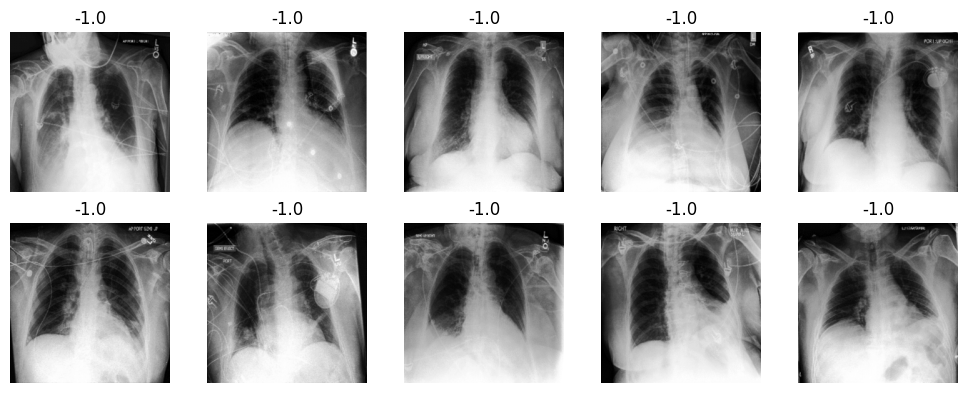

In [ ]:
train_data.reverse()

plot_ranking_images(train_data)
